# Obtención


## Hugging Face


In [ ]:
from datasets import load_dataset

dataset_polaridad = load_dataset(
    "alexcom/analisis-sentimientos-textos-turisitcos-mx-polaridad"
)

In [ ]:
import pandas as pd

df_train_pol = pd.DataFrame(dataset_polaridad["train"])
df_test_pol = pd.DataFrame(dataset_polaridad["test"])

In [ ]:
df_test_pol.head()

,text,label
0,"parece familiar?. probablemente no, ya que se ...",3
1,"el hotel, espectacular. el hotel es muy bonito...",5
2,lugar bueno escondido. amabilidad profesionali...,4
3,situacion privilegiada. hotel con una situacio...,5
4,caminata y visita al cerro monserrate. buen lu...,5


## Análisis Estadístico


<Axes: xlabel='label', ylabel='count'>

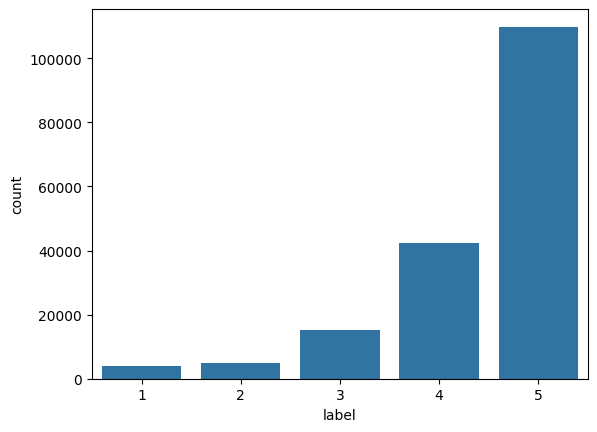

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="label", data=df_train_pol)

In [ ]:
df_train_pol["label"].value_counts()

label
5    109816
4     42232
3     15261
2      4833
1      4050
Name: count, dtype: int64

<Axes: xlabel='label'>

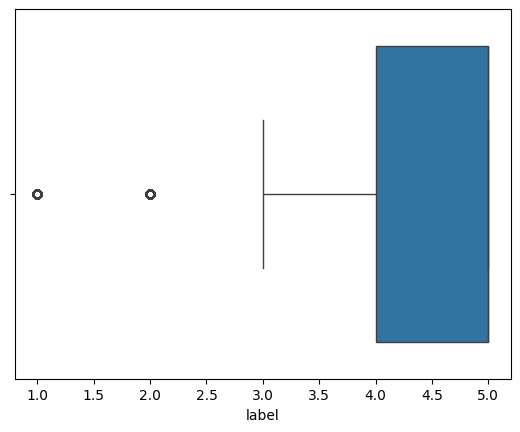

In [ ]:
sns.boxplot(x="label", data=df_train_pol)

## Etiquetado


In [ ]:
def definir_sentimiento(label):
    if label == 5:
        return "Positivo"
    elif label == 4 or label == 3:
        return "Neutro"
    else:
        return "Negativo"

In [ ]:
df_train_pol["Sentimiento"] = df_train_pol["label"].apply(definir_sentimiento)
df_test_pol["Sentimiento"] = df_test_pol["label"].apply(definir_sentimiento)

<Axes: xlabel='Sentimiento', ylabel='count'>

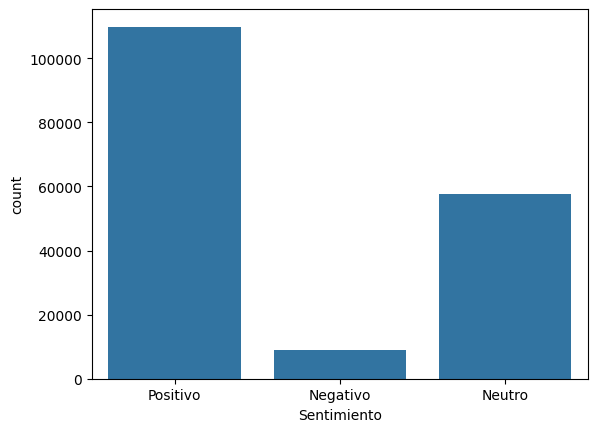

In [ ]:
sns.countplot(x="Sentimiento", data=df_train_pol)

# Preprocesamiento


## Limpieza y Normalización


In [ ]:
import re
import spacy
from wordcloud import WordCloud
from collections import Counter
from tqdm import tqdm

In [ ]:
stopwods_polares = pd.read_csv("stopwords_polares.csv")["stopwords"].tolist()

In [ ]:
def preprocess_text_clean_parallel(
    df, text_column, nlp, num_processes=4, stopwords_extra=stopwods_polares
):
    """
    Preprocesa el texto de forma paralela usando nlp.pipe de spaCy,
    filtrando stopwords y lematizando.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        text_column (str): Nombre de la columna de texto.
        nlp (spacy.Language): Objeto spaCy cargado.
        num_processes (int): Número de procesos (núcleos de CPU) a usar.

    Returns:
        list: Lista de listas, donde cada sublista contiene los tokens limpios (lemas).
    """

    print(f"Iniciando preprocesamiento con {num_processes} procesos...")

    sentences = (
        df[text_column]
        .apply(lambda x: re.sub(r"[^\w\s]", " ", str(x).lower()))
        .apply(lambda x: re.sub(r"\s+", " ", x).strip())
        .to_list()
    )

    docs = nlp.pipe(sentences, batch_size=50, n_process=num_processes)

    token_list = []

    for doc in tqdm(docs, total=len(sentences), desc="Lematizando y Filtrando"):
        cleaned_tokens = [
            x.lemma_.lower()
            for x in doc
            if str(x) in stopwords_extra
            or (not x.is_stop and not x.is_punct and not x.is_space and x.is_alpha)
        ]
        token_list.append(cleaned_tokens)

    return token_list

In [ ]:
def preprocess_text_clean(df, nlp, stopwords_extra=stopwods_polares):
    sentences = (
        df["text"]
        .apply(lambda x: re.sub(r"[^\w\s]", " ", str(x).lower()))
        .apply(lambda x: re.sub(r"\s+", " ", x).strip())
        .to_list()
    )

    docs = []
    # Para mejorar el rendimiento, procesar en lotes con nlp.pipe
    for doc in nlp.pipe(sentences, batch_size=50):
        docs.append(doc)

    token_list = []
    for doc in docs:
        cleaned_tokens = [
            x.lemma_.lower()
            for x in doc
            if str(x) in stopwords_extra
            or (not x.is_stop and not x.is_punct and not x.is_space and x.is_alpha)
        ]
        token_list.append(cleaned_tokens)

    return token_list

In [ ]:
nlp = spacy.load("es_core_news_sm")
corpus_train_pol = preprocess_text_clean_parallel(df_train_pol, "text", nlp, 6)
corpus_test_pol = preprocess_text_clean_parallel(df_test_pol, "text", nlp, 6)

Iniciando preprocesamiento con 6 procesos...


Lematizando y Filtrando: 100%|██████████| 176192/176192 [03:30<00:00, 837.40it/s] 


Iniciando preprocesamiento con 6 procesos...


Lematizando y Filtrando: 100%|██████████| 75510/75510 [01:47<00:00, 701.04it/s] 


In [ ]:
def nube_palabras(listas_palabras: list, targets=None, target_filter=None) -> None:
    palabras = []
    for i in range(len(listas_palabras)):
        if target_filter is None or targets[i] == target_filter:
            palabras.extend(listas_palabras[i])

    print(f"Total de palabras: {len(palabras)}")
    contador = Counter(palabras)
    print("Palabras más comunes:", contador.most_common(10))

    texto = " ".join(palabras)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        texto
    )

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Nubes de Palabras


### Todo el Dataset


Total de palabras: 5597988
Palabras más comunes: [('mucho', 188281), ('no', 126424), ('lugar', 76532), ('hotel', 74266), ('excelente', 62195), ('comida', 58778), ('más', 53906), ('servicio', 53440), ('si', 42010), ('como', 41026)]


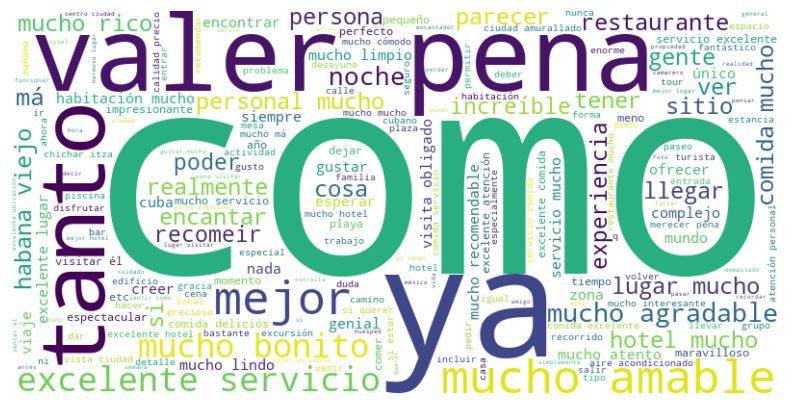

In [ ]:
nube_palabras(corpus_train_pol)

### Clase Positivo


Total de palabras: 3227354
Palabras más comunes: [('mucho', 114022), ('no', 52322), ('excelente', 50433), ('lugar', 48593), ('comida', 37792), ('hotel', 36216), ('servicio', 35065), ('más', 29469), ('mejor', 27695), ('restaurante', 23595)]


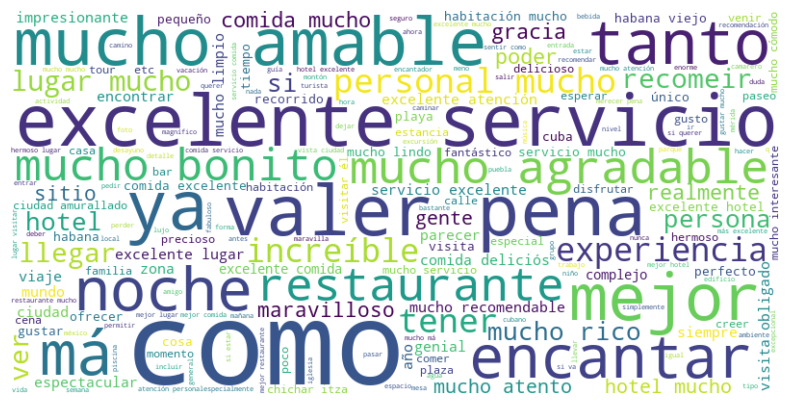

In [ ]:
nube_palabras(
    corpus_train_pol, target_filter="Positivo", targets=df_train_pol["Sentimiento"]
)

### Clase Neutra


Total de palabras: 1980974
Palabras más comunes: [('mucho', 66141), ('no', 55006), ('hotel', 30318), ('lugar', 25020), ('más', 20120), ('comida', 17846), ('habitación', 17785), ('si', 17155), ('como', 15193), ('servicio', 14717)]


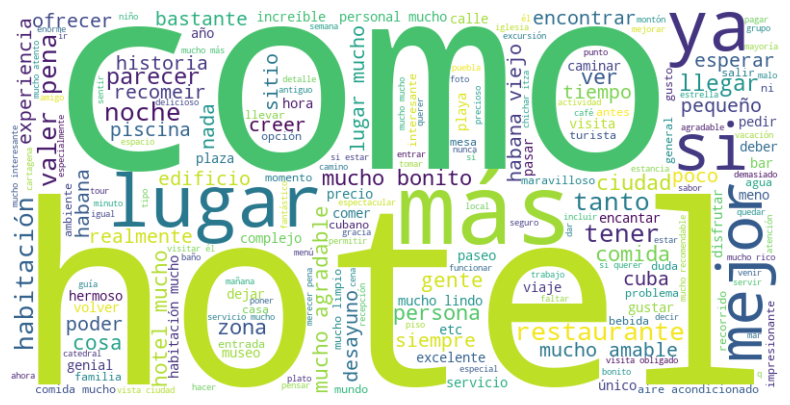

In [ ]:
nube_palabras(
    corpus_train_pol, target_filter="Neutro", targets=df_train_pol["Sentimiento"]
)

### Clase Negativa


Total de palabras: 389660
Palabras más comunes: [('no', 19096), ('mucho', 8118), ('hotel', 7732), ('habitación', 5384), ('más', 4317), ('servicio', 3658), ('como', 3210), ('si', 3196), ('comida', 3140), ('lugar', 2919)]


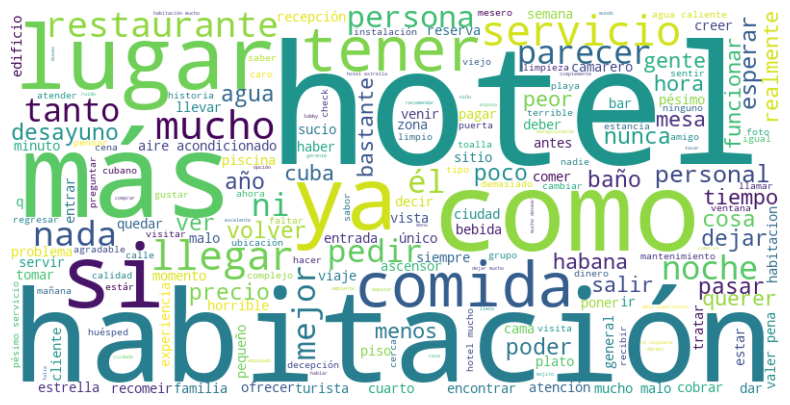

In [ ]:
nube_palabras(
    corpus_train_pol, target_filter="Negativo", targets=df_train_pol["Sentimiento"]
)

# Modelo Espacio Vectorial


## Embedding (FastText)


In [ ]:
import random
import numpy as np
from gensim.models import FastText
from sklearn.manifold import TSNE

In [ ]:
# Código para reducir dimensionalidad y que se puedan graficar las palabras
def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


# Función para graficar
def plot_with_matplotlib(x_vals, y_vals, labels):
    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
    plt.title("Tsne Visualización")
    plt.show()

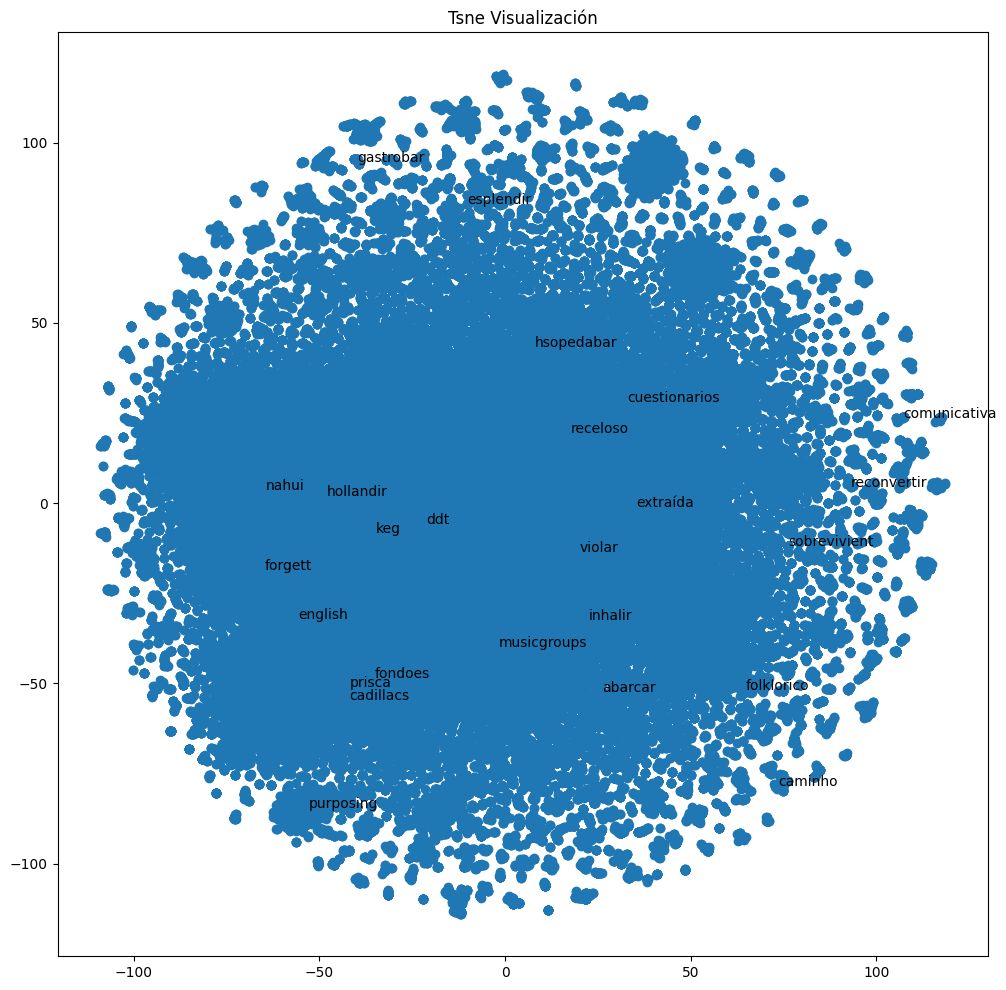

In [ ]:
model_fasttext = FastText(
    sentences=corpus_train_pol,
    vector_size=100,
    window=5,
    min_count=1,
    workers=4,
    sg=1,
    min_n=3,
    max_n=6,
)

x_vals_graph, y_vals_graph, labels_graph = reduce_dimensions(model_fasttext)

plot_with_matplotlib(x_vals_graph, y_vals_graph, labels_graph)

In [ ]:
def vectorizar_documento(tokens_doc, modelo):
    """
    Calcula el vector de documento promediando los vectores de sus palabras.

    Args:
        tokens_doc (list): Lista de tokens (palabras limpias) de un solo documento.
        modelo (FastText): Modelo FastText entrenado.

    Returns:
        np.array: Vector promedio de 100 dimensiones para el documento.
    """

    # Obtener los vectores de las palabras presentes en el vocabulario del modelo
    # FastText es robusto; si una palabra es OOV, construirá un vector a partir de sus sub-palabras.
    vectores = [modelo.wv[token] for token in tokens_doc]

    if not vectores:
        # Devuelve un vector de ceros si el documento está vacío después de la limpieza
        return np.zeros(modelo.vector_size)

    # Calcular la media (promedio) de todos los vectores
    documento_vector = np.mean(vectores, axis=0)
    return documento_vector


def vecotrizacion_corpus(corpus_tokens, model_fasttext):
    X_fasttext = []
    for tokens_doc in corpus_tokens:
        doc_vector = vectorizar_documento(tokens_doc, model_fasttext)
        X_fasttext.append(doc_vector)
    return np.array(X_fasttext)

In [49]:
X_fasttext_train = vecotrizacion_corpus(corpus_train_pol, model_fasttext)
X_fasttext_test = vecotrizacion_corpus(corpus_test_pol, model_fasttext)

## TF-IDF + LSA


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD


def generate_tf_idf_lsa_models(corpus_listas, n_components=100):
    """
    Genera la matriz de características X usando TF-IDF y LSA.

    Args:
        corpus_listas (list): Lista de listas de tokens limpios (corpus).
        n_components (int): Dimensionalidad final deseada (ej. 100).

    Returns:
        np.array: Matriz de características X (Documentos x n_components).
    """

    corpus_cadenas = [" ".join(doc) for doc in corpus_listas]

    print("Calculando matriz TF-IDF...")
    tfidf_vectorizer = TfidfVectorizer(
        min_df=1,
        norm="l2",
    )
    X_tfidf = tfidf_vectorizer.fit_transform(corpus_cadenas)
    print(f"Aplicando LSA para reducir a {n_components} dimensiones...")
    lsa_model = TruncatedSVD(n_components=n_components, random_state=42)
    lsa_model.fit(X_tfidf)
    return tfidf_vectorizer, lsa_model


def generate_lsa_features(corpus_listas, tf_idf, lsa, n_components=100):
    """
    Genera la matriz de características X usando TF-IDF y LSA.

    Args:
        corpus_listas (list): Lista de listas de tokens limpios (corpus).
        tf_idf (TfidfVectorizer): Modelo TF-IDF preentrenado.
        lsa (TruncatedSVD): Modelo LSA preentrenado.
        n_components (int): Dimensionalidad final deseada (ej. 100).
    Returns:
        np.array: Matriz de características X (Documentos x n_components).
    """
    corpus_cadenas = [" ".join(doc) for doc in corpus_listas]

    X_tfidf = tf_idf.transform(corpus_cadenas)
    print(f"Dimensiones iniciales (TF-IDF): {X_tfidf.shape}")
    X_lsa = lsa.transform(X_tfidf)
    print(f"Dimensiones finales (LSA): {X_lsa.shape}")
    return X_lsa

In [ ]:
tf_idf, lsa = generate_tf_idf_lsa_models(
    corpus_listas=corpus_train_pol, n_components=100
)

Calculando matriz TF-IDF...
Aplicando LSA para reducir a 100 dimensiones...


In [50]:
X_lsa_train = generate_lsa_features(
    corpus_listas=corpus_train_pol, tf_idf=tf_idf, lsa=lsa, n_components=100
)
X_lsa_test = generate_lsa_features(
    corpus_listas=corpus_test_pol, tf_idf=tf_idf, lsa=lsa, n_components=100
)

Dimensiones iniciales (TF-IDF): (176192, 93624)
Dimensiones finales (LSA): (176192, 100)
Dimensiones iniciales (TF-IDF): (75510, 93624)
Dimensiones finales (LSA): (75510, 100)


## Comparar modelos


In [ ]:
X_lsa_train[0], X_fasttext_train[0]

(array([ 1.47940059e-01, -2.44813565e-02, -1.24741037e-01,  9.77228435e-04,
        -1.95782225e-02,  1.14825438e-02, -4.11783560e-02,  5.21599751e-02,
         6.42785271e-02,  1.05318349e-01, -1.11967212e-01, -3.99537242e-02,
        -1.94842127e-02,  6.92291126e-02, -3.35240314e-02,  5.89816880e-03,
         1.31084725e-02, -7.23624472e-02, -4.70990766e-03, -4.11268972e-02,
         3.75399622e-02, -4.80747879e-02, -1.12453805e-02,  6.79553557e-02,
         2.06400480e-02, -5.07244563e-02, -6.23612306e-02,  6.48891566e-02,
        -2.35564727e-02,  3.69673411e-02,  1.61858133e-02,  3.32727093e-02,
         1.66115351e-03, -7.80524619e-03,  2.52994296e-02, -2.89783615e-02,
         2.40548454e-03,  6.00779971e-02,  1.99108846e-02, -2.37220146e-04,
        -5.62288155e-03, -4.36349698e-02,  2.45937139e-03,  2.65653168e-02,
         1.68230136e-03,  2.76807071e-02, -7.12026776e-02,  1.38832953e-02,
        -4.98305001e-02, -1.34067149e-02, -1.15194169e-02,  5.40996194e-03,
         7.0

# Balanceo de Clases


In [ ]:
y_train = df_train_pol["Sentimiento"].values
y_test = df_test_pol["Sentimiento"].values

In [ ]:
len(y_train), len(X_lsa_train), len(X_fasttext_train)

(176192, 176192, 176192)

In [ ]:
from imblearn.under_sampling import NearMiss

sampler = NearMiss(version=3, n_neighbors_ver3=3)

# Para LSA
X_lsa_train_resampled, Y_lsa_train_resampled = sampler.fit_resample(
    X_lsa_train, y_train
)


sampler = NearMiss(version=3, n_neighbors_ver3=3)
# FastText
sampler_ft = NearMiss(version=3, n_neighbors_ver3=3)
X_fasttext_train_resampled, Y_fasttext_train_resampled = sampler_ft.fit_resample(
    X_fasttext_train, y_train
)

c:\Users\jlflo\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\jlflo\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\jlflo\AppData\Local\Programs\Python\Python312\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:206: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\jlflo\AppData

In [ ]:
len(Y_lsa_train_resampled), len(X_lsa_train_resampled)

(25609, 25609)

# Covalores


## Añadir covalores mediante diccionarios


In [ ]:
# Diccionario de palabras positivas y negativas en español
palabras_positivas = {
    "excelente",
    "bueno",
    "genial",
    "increíble",
    "fantástico",
    "maravilloso",
    "perfecto",
    "amor",
    "feliz",
    "alegría",
    "hermoso",
    "bello",
    "mejor",
    "grande",
    "éxito",
    "victoria",
    "ganar",
    "positivo",
    "espectacular",
    "extraordinario",
    "agradable",
    "encantador",
    "satisfecho",
    "optimista",
    "afortunado",
    "bendición",
    "triunfo",
    "magnífico",
    "sublime",
    "divino",
    "precioso",
    "adorable",
    "brillante",
    "sobresaliente",
    "fabuloso",
    "sensacional",
    "estupendo",
    "chévere",
    "padre",
    "chido",
    "cool",
    "guay",
    "bonito",
    "lindo",
    "rico",
    "sabroso",
    "delicioso",
}

palabras_negativas = {
    "malo",
    "terrible",
    "horrible",
    "pésimo",
    "awful",
    "peor",
    "odio",
    "triste",
    "tristeza",
    "dolor",
    "feo",
    "desagradable",
    "fracaso",
    "perder",
    "negativo",
    "desastre",
    "deficiente",
    "insatisfecho",
    "pesimista",
    "infeliz",
    "amargo",
    "molesto",
    "enojado",
    "furioso",
    "decepción",
    "lamentable",
    "deplorable",
    "espantoso",
    "atroz",
    "abominable",
    "detestable",
    "repugnante",
    "asqueroso",
    "sucio",
    "miserable",
    "patético",
    "lástima",
    "cruel",
    "duro",
    "difícil",
    "complicado",
    "problema",
    "error",
    "falla",
    "defecto",
}

# Palabras de negación que invierten el sentimiento
palabras_negacion = {
    "no",
    "nunca",
    "jamás",
    "tampoco",
    "ningún",
    "ninguna",
    "nada",
    "nadie",
}


def calcular_sentimiento_lexico(texto):
    """
    Calcula scores de sentimiento usando diccionarios en español.
    Retorna: [score_positivo, score_negativo, score_total, ratio]
    """
    palabras = texto.lower().split()

    score_pos = 0
    score_neg = 0

    for i, palabra in enumerate(palabras):
        # Verificar si hay negación antes de la palabra
        negacion = False
        if i > 0 and palabras[i - 1] in palabras_negacion:
            negacion = True

        # Contar palabras positivas
        if palabra in palabras_positivas:
            if negacion:
                score_neg += 1  # "no bueno" se cuenta como negativo
            else:
                score_pos += 1

        # Contar palabras negativas
        if palabra in palabras_negativas:
            if negacion:
                score_pos += 1  # "no malo" se cuenta como positivo
            else:
                score_neg += 1

    # Score total y ratio
    score_total = score_pos - score_neg
    ratio = score_pos / (score_neg + 1)  # +1 para evitar división por cero

    return [score_pos, score_neg, score_total, ratio]


def extraer_features_diccionario(textos):
    """
    Aplica el diccionario de sentimientos a todos los textos.
    """
    features = [calcular_sentimiento_lexico(texto) for texto in textos]
    return np.array(features)

In [54]:
X_train_text = df_train_pol["text"].tolist()
X_test_text = df_test_pol["text"].tolist()
indices_lsa_resampled = pd.DataFrame(X_lsa_train_resampled).index.to_numpy()
indices_fasttext_resampled = pd.DataFrame(X_fasttext_train_resampled).index.to_numpy()

# Diccionario de sentimientos
dict_features_train_full = extraer_features_diccionario(X_train_text)
dict_features_test = extraer_features_diccionario(X_test_text)
dict_features_lsa_train_resampled = dict_features_train_full[indices_lsa_resampled]
dict_features_fasttext_train_resampled = dict_features_train_full[
    indices_fasttext_resampled
]

X_lsa_train_resampled = np.hstack(
    [X_lsa_train_resampled, dict_features_lsa_train_resampled]
)

X_lsa_test = np.hstack([X_lsa_test, dict_features_test])

X_fasttext_train_resampled = np.hstack(
    [X_fasttext_train_resampled, dict_features_fasttext_train_resampled]
)
X_fasttext_test = np.hstack([X_fasttext_test, dict_features_test])

In [ ]:
print(
    f"Shape features diccionario train: {dict_features_fasttext_train_resampled.shape}"
)
print(f"Ejemplo features diccionario: {dict_features_fasttext_train_resampled[0]}")
print("Columnas: [score_pos, score_neg, score_total, ratio_pos/neg]")

Shape features diccionario train: (23670, 4)
Ejemplo features diccionario: [2. 0. 2. 2.]
Columnas: [score_pos, score_neg, score_total, ratio_pos/neg]


# Entrenamiento


## Random Forest


In [57]:
from sklearn.ensemble import RandomForestClassifier

rf_lsa = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lsa.fit(X_lsa_train_resampled, Y_lsa_train_resampled)
rf_fasttext = RandomForestClassifier(n_estimators=100, random_state=42)
rf_fasttext.fit(X_fasttext_train_resampled, Y_fasttext_train_resampled)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Naive Bayes


In [58]:
from sklearn.naive_bayes import GaussianNB

gnb_lsa = GaussianNB()
gnb_lsa.fit(X_lsa_train_resampled, Y_lsa_train_resampled)
gnb_fasttext = GaussianNB()
gnb_fasttext.fit(X_fasttext_train_resampled, Y_fasttext_train_resampled)

,priors,None
,var_smoothing,1e-09


## SVM


In [59]:
from sklearn.svm import SVC

svm_lsa = SVC(kernel="linear", random_state=42)
svm_lsa.fit(X_lsa_train_resampled, Y_lsa_train_resampled)
svm_fasttext = SVC(kernel="linear", random_state=42)
svm_fasttext.fit(X_fasttext_train_resampled, Y_fasttext_train_resampled)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


# Refinamiento de modelos / Testing


## Función de Cross-Validation y Búsqueda de mejores Hiperparámetros


In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


def busqueda_paralela_hiperparametros(
    modelo_base, X_train, Y_train, parametros_a_probar, cv=5, scoring="f1_weighted"
):
    """
    Realiza una búsqueda exhaustiva de hiperparámetros con validación cruzada (GridSearchCV)
    utilizando todos los núcleos de CPU disponibles (n_jobs=-1).

    Args:
        modelo_base (sklearn estimator): El modelo de clasificación base (ej. RandomForestClassifier()).
        X_train (np.array): Matriz de características de entrenamiento vectorizadas.
        Y_train (np.array): Vector de etiquetas de entrenamiento (codificadas numéricamente).
        parametros_a_probar (dict): Diccionario de parámetros y valores a explorar.
        cv (int): Número de pliegues (folds) para la validación cruzada (default 5).
        scoring (str): Métrica de evaluación a optimizar (default 'f1_weighted', ideal para clases desbalanceadas).

    Returns:
        tuple: (Modelo GridSearchCV entrenado, Diccionario de los mejores parámetros).
    """

    # 1. Mensaje de inicio y métricas
    print("---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---")
    print(f"Modelo: {type(modelo_base).__name__}")
    print(f"Número de Muestras de Entrenamiento: {X_train.shape[0]}")
    print(f"Optimizando la métrica: {scoring}")

    # 2. Configuración de GridSearchCV
    # n_jobs=-1: Usa todos los núcleos de CPU.
    # refit=True: Entrena el mejor modelo con todos los datos de entrenamiento al final.
    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=parametros_a_probar,
        scoring=scoring,
        cv=cv,
        verbose=3,
        n_jobs=-1,
        refit=True,
    )

    # 3. Entrenamiento (Búsqueda)
    grid_search.fit(X_train, Y_train)

    # 4. Reporte de Resultados
    print("\n---Resultados de la Búsqueda Exhaustiva ---")
    print(f"Mejor Puntuación ({scoring}): {grid_search.best_score_:.4f}")
    print(f"Mejores Parámetros Encontrados: {grid_search.best_params_}")

    # 5. Reporte de Clasificación del Mejor Modelo
    print("\n--- Reporte de Clasificación del Mejor Modelo (Usando CV) ---")
    y_pred = grid_search.best_estimator_.predict(X_train)

    print(classification_report(Y_train, y_pred, zero_division=0))

    return grid_search, grid_search.best_params_

## Random Forest


In [61]:
import warnings

warnings.filterwarnings("ignore")


rf_base = RandomForestClassifier(
    random_state=42,
    oob_score=True,
)

parametros_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15],
    "min_samples_split": [10, 20, 50],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", "log2"],
}

mejor_rf_lsa_gs, mejores_parametros_rf = busqueda_paralela_hiperparametros(
    modelo_base=rf_base,
    X_train=X_lsa_train_resampled,
    Y_train=Y_lsa_train_resampled,
    parametros_a_probar=parametros_rf,
    cv=3,
    scoring="f1_weighted",
)

rf_base = RandomForestClassifier(random_state=42, oob_score=True)

mejor_rf_fasttext_gs, mejores_parametros_rf = busqueda_paralela_hiperparametros(
    modelo_base=rf_base,
    X_train=X_fasttext_train_resampled,
    Y_train=Y_fasttext_train_resampled,
    parametros_a_probar=parametros_rf,
    cv=3,
    scoring="f1_weighted",
)

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: RandomForestClassifier
Número de Muestras de Entrenamiento: 25609
Optimizando la métrica: f1_weighted
Fitting 3 folds for each of 162 candidates, totalling 486 fits

---Resultados de la Búsqueda Exhaustiva ---
Mejor Puntuación (f1_weighted): 0.4491
Mejores Parámetros Encontrados: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 100}

--- Reporte de Clasificación del Mejor Modelo (Usando CV) ---
              precision    recall  f1-score   support

    Negativo       0.72      0.82      0.77      8883
      Neutro       0.75      0.54      0.63      8576
    Positivo       0.70      0.81      0.75      8150

    accuracy                           0.72     25609
   macro avg       0.72      0.72      0.71     25609
weighted avg       0.72      0.72      0.71     25609

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: RandomForestClassifier
Nú

## Naive Bayes


In [62]:
naive_bayes_base = GaussianNB()

parametros_naive_bayes = {
    "var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6],
}

mejor_gnb_lsa_gs, mejores_parametros_gnb = busqueda_paralela_hiperparametros(
    modelo_base=naive_bayes_base,
    X_train=X_lsa_train_resampled,
    Y_train=Y_lsa_train_resampled,
    parametros_a_probar=parametros_naive_bayes,
    cv=3,
    scoring="f1_weighted",
)

naive_bayes_base = GaussianNB()

mejor_gnb_fasttext_gs, mejores_parametros_gnb = busqueda_paralela_hiperparametros(
    modelo_base=naive_bayes_base,
    X_train=X_fasttext_train_resampled,
    Y_train=Y_fasttext_train_resampled,
    parametros_a_probar=parametros_naive_bayes,
    cv=3,
    scoring="f1_weighted",
)

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: GaussianNB
Número de Muestras de Entrenamiento: 25609
Optimizando la métrica: f1_weighted
Fitting 3 folds for each of 4 candidates, totalling 12 fits

---Resultados de la Búsqueda Exhaustiva ---
Mejor Puntuación (f1_weighted): 0.3793
Mejores Parámetros Encontrados: {'var_smoothing': 1e-06}

--- Reporte de Clasificación del Mejor Modelo (Usando CV) ---
              precision    recall  f1-score   support

    Negativo       0.56      0.56      0.56      8883
      Neutro       0.42      0.33      0.37      8576
    Positivo       0.53      0.66      0.59      8150

    accuracy                           0.51     25609
   macro avg       0.50      0.51      0.51     25609
weighted avg       0.50      0.51      0.50     25609

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: GaussianNB
Número de Muestras de Entrenamiento: 23670
Optimizando la métrica: f1_weighted
Fitting 3 folds for each of 4 candida

## SVM


In [63]:
svm_base = SVC(random_state=42)

parametros_svm = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.001, 0.01],
    "kernel": ["rbf", "linear"],
}

mejor_svm_lsa_gs, mejores_parametros_svm = busqueda_paralela_hiperparametros(
    modelo_base=svm_base,
    X_train=X_lsa_train_resampled,
    Y_train=Y_lsa_train_resampled,
    parametros_a_probar=parametros_svm,
    cv=3,
    scoring="f1_weighted",
)
svm_base = SVC(random_state=42)

mejor_svm_fasttext_gs, mejores_parametros_svm = busqueda_paralela_hiperparametros(
    modelo_base=svm_base,
    X_train=X_fasttext_train_resampled,
    Y_train=Y_fasttext_train_resampled,
    parametros_a_probar=parametros_svm,
    cv=3,
    scoring="f1_weighted",
)

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: SVC
Número de Muestras de Entrenamiento: 25609
Optimizando la métrica: f1_weighted
Fitting 3 folds for each of 18 candidates, totalling 54 fits

---Resultados de la Búsqueda Exhaustiva ---
Mejor Puntuación (f1_weighted): 0.5277
Mejores Parámetros Encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

--- Reporte de Clasificación del Mejor Modelo (Usando CV) ---
              precision    recall  f1-score   support

    Negativo       0.67      0.67      0.67      8883
      Neutro       0.49      0.42      0.45      8576
    Positivo       0.62      0.72      0.67      8150

    accuracy                           0.60     25609
   macro avg       0.59      0.60      0.59     25609
weighted avg       0.59      0.60      0.59     25609

---Iniciando Búsqueda de Hiperparámetros con Paralelismo ---
Modelo: SVC
Número de Muestras de Entrenamiento: 23670
Optimizando la métrica: f1_weighted
Fitting 3 folds for each of

# Evaluación


## Función de Evaluación


In [64]:
from sklearn.metrics import confusion_matrix


def evaluar_modelo_en_test(modelo_gs, X_test, Y_test, gs=True):
    """
    Evalúa el modelo entrenado en el conjunto de prueba y muestra el reporte de clasificación.

    Args:
        modelo_gs (GridSearchCV): Modelo GridSearchCV entrenado.
        X_test (np.array): Matriz de características del conjunto de prueba.
        Y_test (np.array): Vector de etiquetas verdaderas del conjunto de prueba.
    """

    print("\n--- Evaluación en el Conjunto de Prueba ---")
    if not gs:
        y_pred_test = modelo_gs.predict(X_test)
    else:
        y_pred_test = modelo_gs.best_estimator_.predict(X_test)
    print(classification_report(Y_test, y_pred_test, zero_division=0))
    mc = confusion_matrix(Y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(mc, annot=True, fmt="d", cmap="Blues")

## Random Forest


### Módelo sin Refinar



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.19      0.70      0.30      3841
      Neutro       0.43      0.34      0.38     24390
    Positivo       0.75      0.67      0.71     47279

    accuracy                           0.57     75510
   macro avg       0.46      0.57      0.46     75510
weighted avg       0.62      0.57      0.58     75510



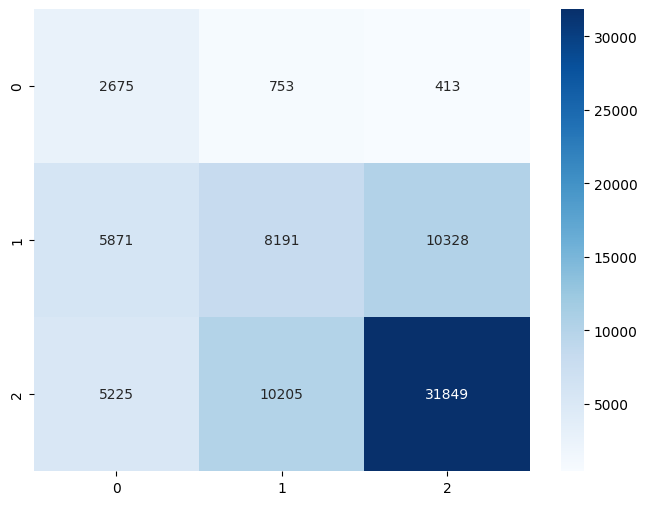

In [65]:
evaluar_modelo_en_test(rf_lsa, X_lsa_test, y_test, gs=False)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.47      0.71      0.56      3841
      Neutro       0.53      0.37      0.44     24390
    Positivo       0.75      0.83      0.79     47279

    accuracy                           0.68     75510
   macro avg       0.58      0.64      0.60     75510
weighted avg       0.66      0.68      0.66     75510



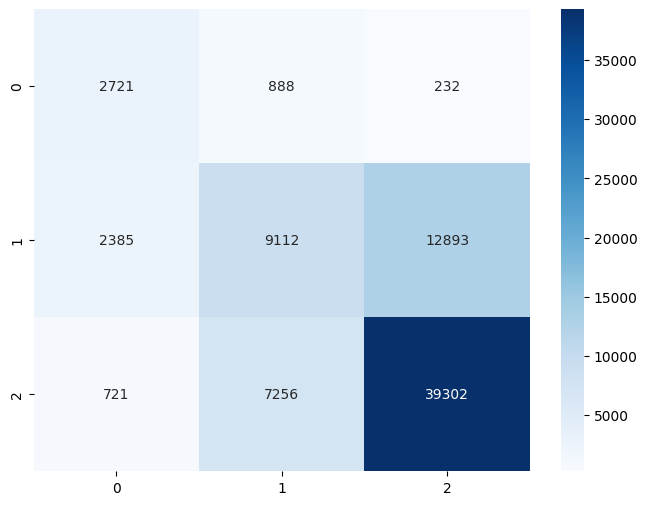

In [66]:
evaluar_modelo_en_test(rf_fasttext, X_fasttext_test, y_test, gs=False)

### Módelo Refinado



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.20      0.71      0.31      3841
      Neutro       0.52      0.22      0.31     24390
    Positivo       0.74      0.81      0.77     47279

    accuracy                           0.61     75510
   macro avg       0.49      0.58      0.47     75510
weighted avg       0.64      0.61      0.60     75510



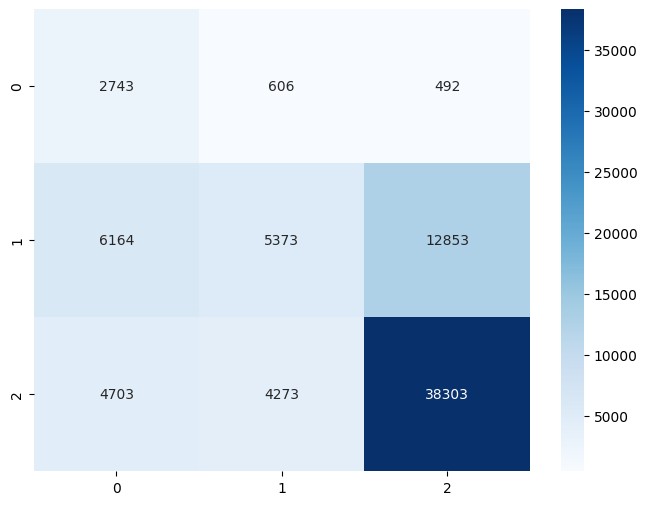

In [67]:
# Modelo Random Forest con LSA
evaluar_modelo_en_test(mejor_rf_lsa_gs, X_lsa_test, y_test)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.49      0.70      0.58      3841
      Neutro       0.63      0.34      0.44     24390
    Positivo       0.75      0.91      0.82     47279

    accuracy                           0.71     75510
   macro avg       0.63      0.65      0.61     75510
weighted avg       0.70      0.71      0.68     75510



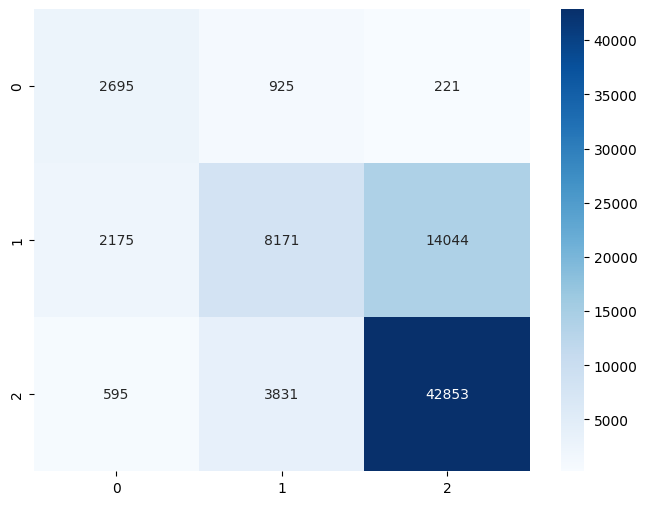

In [68]:
# Modelo Random Forest con FastText
evaluar_modelo_en_test(mejor_rf_fasttext_gs, X_fasttext_test, y_test)

## Naive Bayes


### Módelo sin Refinar



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.05      0.56      0.09      3841
      Neutro       0.51      0.13      0.21     24390
    Positivo       0.72      0.42      0.53     47279

    accuracy                           0.33     75510
   macro avg       0.43      0.37      0.28     75510
weighted avg       0.62      0.33      0.40     75510



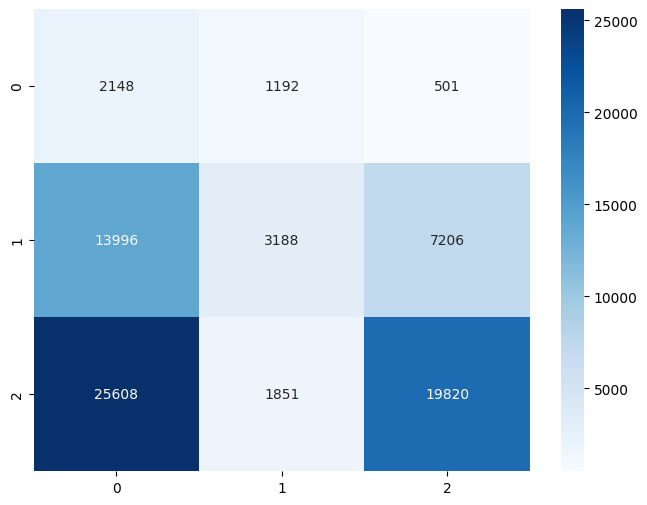

In [69]:
evaluar_modelo_en_test(gnb_lsa, X_lsa_test, y_test, gs=False)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.48      0.60      0.53      3841
      Neutro       0.61      0.21      0.31     24390
    Positivo       0.71      0.94      0.81     47279

    accuracy                           0.69     75510
   macro avg       0.60      0.58      0.55     75510
weighted avg       0.67      0.69      0.63     75510



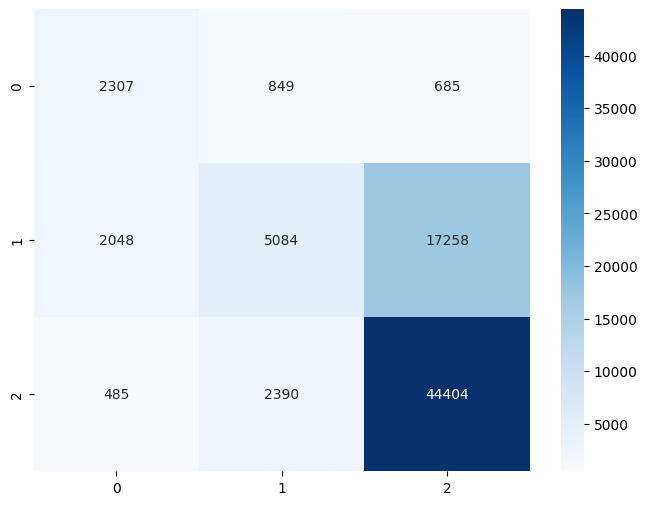

In [70]:
evaluar_modelo_en_test(gnb_fasttext, X_fasttext_test, y_test, gs=False)

### Módelo Refinado



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.05      0.56      0.09      3841
      Neutro       0.51      0.13      0.21     24390
    Positivo       0.72      0.42      0.53     47279

    accuracy                           0.33     75510
   macro avg       0.43      0.37      0.28     75510
weighted avg       0.62      0.33      0.40     75510



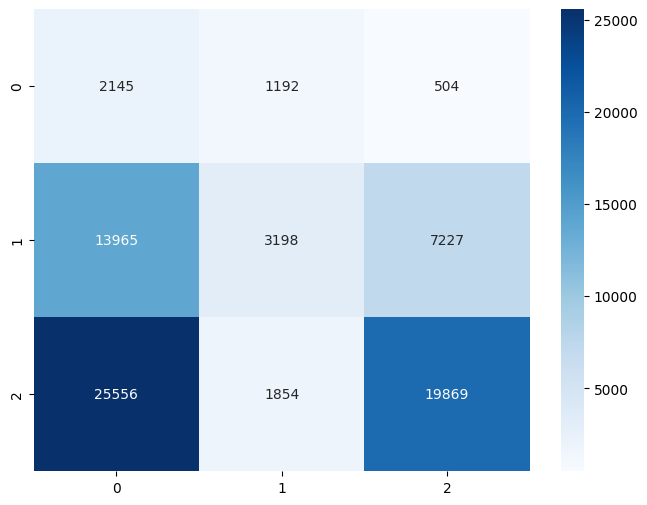

In [71]:
evaluar_modelo_en_test(mejor_gnb_lsa_gs, X_lsa_test, y_test)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.48      0.60      0.53      3841
      Neutro       0.61      0.21      0.31     24390
    Positivo       0.71      0.94      0.81     47279

    accuracy                           0.69     75510
   macro avg       0.60      0.58      0.55     75510
weighted avg       0.67      0.69      0.63     75510



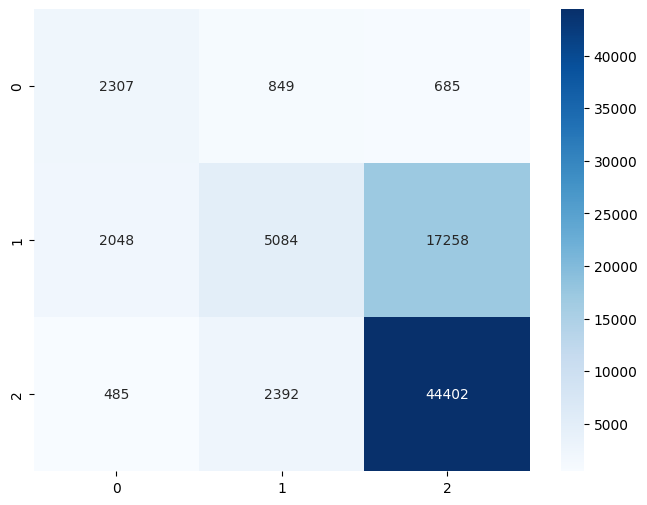

In [72]:
evaluar_modelo_en_test(mejor_gnb_fasttext_gs, X_fasttext_test, y_test)

## SVM


### Módelo sin Refinar



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.32      0.66      0.43      3841
      Neutro       0.64      0.25      0.36     24390
    Positivo       0.74      0.91      0.82     47279

    accuracy                           0.69     75510
   macro avg       0.57      0.61      0.54     75510
weighted avg       0.69      0.69      0.65     75510



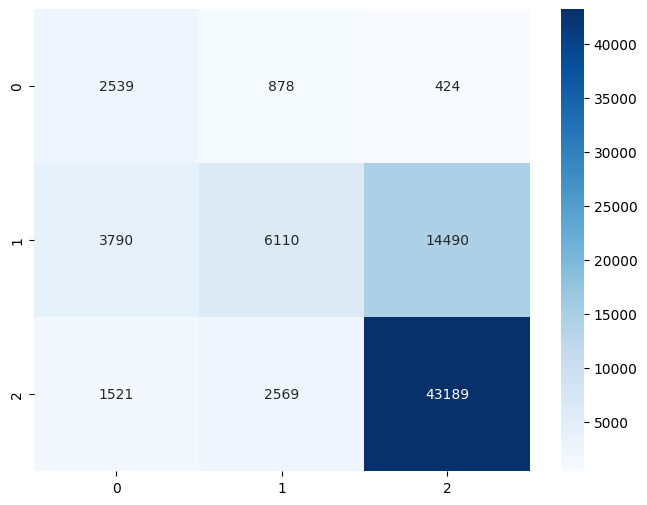

In [73]:
evaluar_modelo_en_test(svm_lsa, X_lsa_test, y_test, gs=False)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.54      0.68      0.60      3841
      Neutro       0.67      0.35      0.46     24390
    Positivo       0.75      0.93      0.83     47279

    accuracy                           0.73     75510
   macro avg       0.66      0.65      0.63     75510
weighted avg       0.72      0.73      0.70     75510



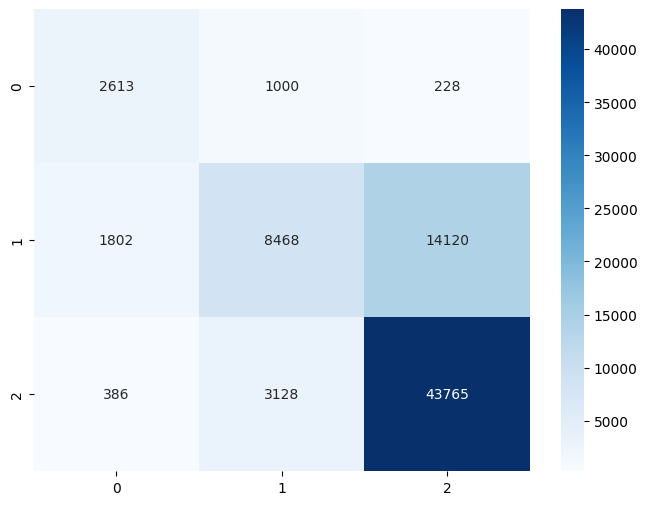

In [74]:
evaluar_modelo_en_test(svm_fasttext, X_fasttext_test, y_test, gs=False)

### Módelo Refinado



--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.32      0.66      0.43      3841
      Neutro       0.63      0.26      0.37     24390
    Positivo       0.75      0.91      0.82     47279

    accuracy                           0.69     75510
   macro avg       0.57      0.61      0.54     75510
weighted avg       0.69      0.69      0.65     75510



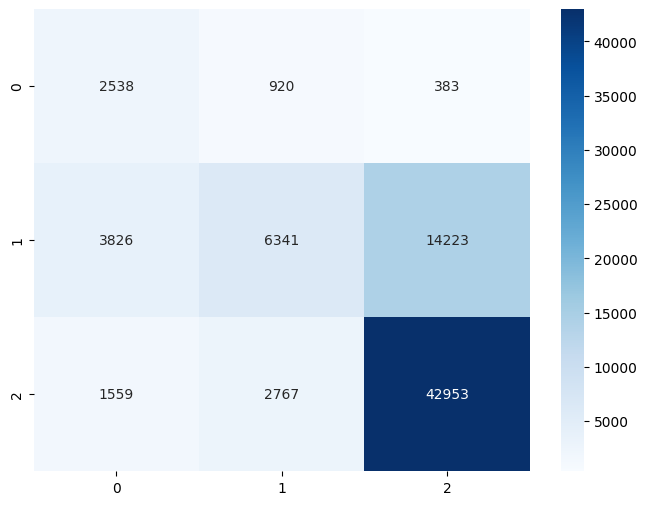

In [75]:
evaluar_modelo_en_test(mejor_svm_lsa_gs, X_lsa_test, y_test)


--- Evaluación en el Conjunto de Prueba ---
              precision    recall  f1-score   support

    Negativo       0.53      0.68      0.60      3841
      Neutro       0.67      0.35      0.46     24390
    Positivo       0.75      0.92      0.83     47279

    accuracy                           0.73     75510
   macro avg       0.65      0.65      0.63     75510
weighted avg       0.72      0.73      0.70     75510



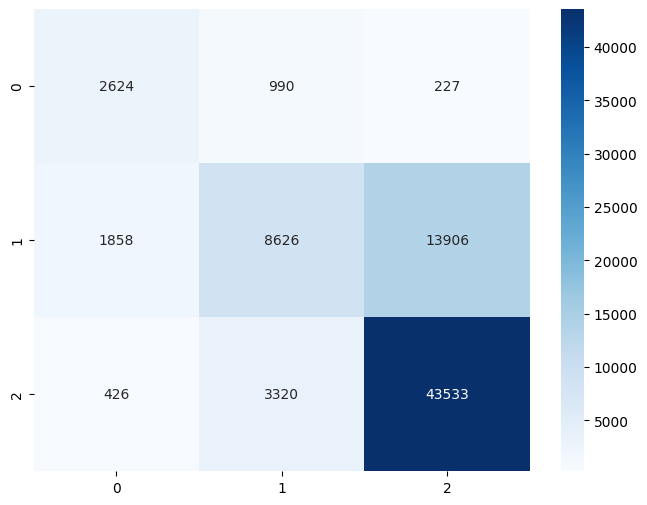

In [76]:
evaluar_modelo_en_test(mejor_svm_fasttext_gs, X_fasttext_test, y_test)